In [1]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
from itertools import groupby
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2.2.2


In [2]:
###### Loading Molecular Interactions Data #######

base = '/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/lig47_data/'

df = pd.read_pickle(base + "lig47_hbonds_dict")

frames = [df[key]['distances'] for key in df.keys()]
combined = np.concatenate(frames, axis=1)
print(combined.shape)

dfaro = np.load(base + "aro_contacts.npy")

dcharges = np.load(base + "charge_dist_matrix.npy")
print(dcharges.shape)

hydrodf = pd.read_pickle(base + "hphbob_dict_lig47")

frames = [hydrodf[key]['distance'] for key in hydrodf.keys()]
hydrocombined = np.concatenate(frames, axis=1)
print(hydrocombined.shape)

dmat = np.load(base + "distance_matrix_full_LIG.npy")
print(dmat.shape)

def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]


(1100889, 314)
(1100889, 9)
(1100889, 1500)
(1100889, 20)


In [4]:
###### Initial PCA on each dataframe #######
# Memory Constraints make this approach easier before combining
from sklearn.decomposition import PCA

pca1 = PCA(n_components=4, whiten=True)

pca1.fit(combined)
hbond_pca = pca1.transform(combined)

pca2 = PCA(n_components=4, whiten=True)

pca2.fit(dcharges)
charges_pca = pca2.transform(dcharges)

pca3 = PCA(n_components=4, whiten=True)

pca3.fit(hydrocombined)
hydro_pca = pca3.transform(hydrocombined)


In [5]:
###### Final PCA #######

all_input = np.concatenate([hydro_pca, charges_pca, hbond_pca, dfaro], axis=1)
print(all_input.shape)
pca_all12 = PCA(n_components=12, whiten=True)

pca_all12.fit(all_input)
inputs_pca12 = pca_all12.transform(all_input)

(1100889, 15)


In [6]:
print(inputs_pca12.shape) #Verify final shape matches intended columns

(1100889, 12)


In [19]:
inputs_pca = inputs_pca12

events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(inputs_pca[0,:])])
representative_frames_all = np.zeros(len(events_all), dtype=int)

# Building arrays for events and avg data inputs
count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(inputs_pca[event[0]:event[-1]+1], axis=0)
  count += 1
  

# Getting different ranges
mapping = mapping_all[mapping_all > 4]
avg = avg_all[mapping_all > 4]

print("Total Events At Least 5 Frames:",len(representative_frames))

scores = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/Residence_Time_Prediction/Docking_Scores/docking_scores.npy")

print("loaded scores:", len(scores))

# Filtering out nan scores
mapping = mapping[scores != -999]
avg = avg[scores != -999]
scores = scores[scores != -999]

# setting 98% range
scores = scores[mapping < 477]
avg = avg[mapping < 477]
mapping = mapping[mapping < 477]

print(len(scores), len(representative_frames), len(mapping))

# Train test split, doing it deterministically for repeatable results
N = len(mapping)
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

# Scaling inputs for better gradient
scaled = mapping/100
print("max scaled ength:",np.max(mapping))
print("min scaled length:",np.min(mapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

# Processing inputs for TabNet
a1 = std_avg[train_indices]
m1 = scaled[train_indices]
a2 = std_avg[val_indices]
m2 = scaled[val_indices]
a3 = std_avg[test_indices]
m3 = scaled[test_indices]
s3 = scores[test_indices]

a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

print(a1.shape)

# Setting up TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

# Predict Test set
preds = clf.predict(a3)
preds = preds[:,0]

Total Events At Least 5 Frames: 11270
loaded scores: 11602
11270 11270 11270
max log length: 476.0
min log length: 5.0
mean: [ 0.40975655  0.05678234 -0.04823281 -0.18749733 -0.02451667  0.03904093
  0.04575679  0.14353698  0.02841476 -0.06289128 -0.28527946 -0.0420563 ]
std deviation: [0.71628035 0.94826411 0.93048089 0.7854661  0.78351109 0.74940837
 0.66184958 0.68161909 0.52716959 0.57776358 0.57618494 0.69166488]
standardized avg distance data
(7888, 12)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.27719 | val_0_mse: 0.70158 |  0:00:00s
epoch 1  | loss: 0.63434 | val_0_mse: 0.52632 |  0:00:00s
epoch 2  | loss: 0.54214 | val_0_mse: 0.48456 |  0:00:00s
epoch 3  | loss: 0.49968 | val_0_mse: 0.45248 |  0:00:01s
epoch 4  | loss: 0.47375 | val_0_mse: 0.44415 |  0:00:01s
epoch 5  | loss: 0.45386 | val_0_mse: 0.42442 |  0:00:01s
epoch 6  | loss: 0.43376 | val_0_mse: 0.4132  |  0:00:02s
epoch 7  | loss: 0.40538 | val_0_mse: 0.41181 |  0:00:02s
epoch 8  | loss: 0.40949 | val_0_mse: 0.39636 |  0:00:02s
epoch 9  | loss: 0.38592 | val_0_mse: 0.37992 |  0:00:02s
epoch 10 | loss: 0.37808 | val_0_mse: 0.38338 |  0:00:03s
epoch 11 | loss: 0.36349 | val_0_mse: 0.37343 |  0:00:03s
epoch 12 | loss: 0.34233 | val_0_mse: 0.36155 |  0:00:03s
epoch 13 | loss: 0.34805 | val_0_mse: 0.34372 |  0:00:04s
epoch 14 | loss: 0.34321 | val_0_mse: 0.35709 |  0:00:04s
epoch 15 | loss: 0.34446 | val_0_mse: 0.36692 |  0:00:04s
epoch 16 | loss: 0.32925 | val_0_mse: 0.34279 |  0:00:04s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Text(0.5, 0, 'Ordered Longest Events')

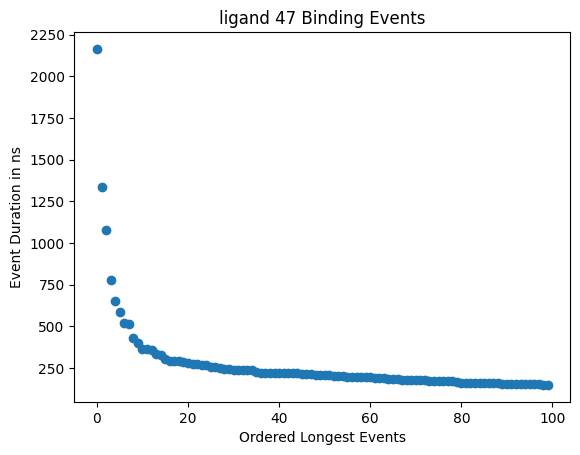

In [47]:
#Plotting event distriubution
plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

plt.scatter(np.arange(100), plotevents[:100]*180e-3)
plt.title("ligand 47 Binding Events") 
plt.ylabel("Event Duration in ns")
plt.xlabel("Ordered Longest Events")

Text(0.5, 1.0, 'Binding Events Over Time')

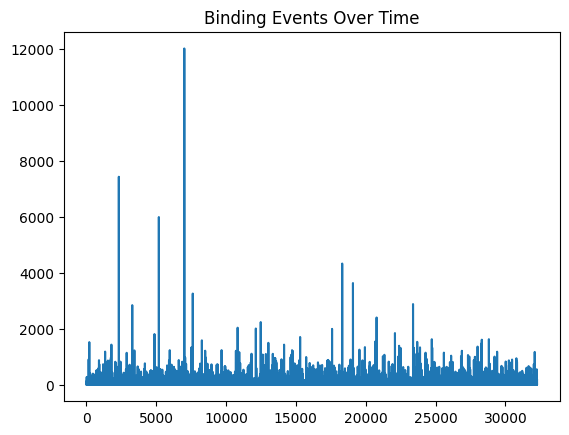

In [45]:
#Plotting event distriubution
plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
ploteventsintime = np.array([len(i) for i in events_all])
plt.plot(ploteventsintime)
plt.title("Binding Events Over Time")

Text(0.5, 1.0, 'Distribution of Docking Scores')

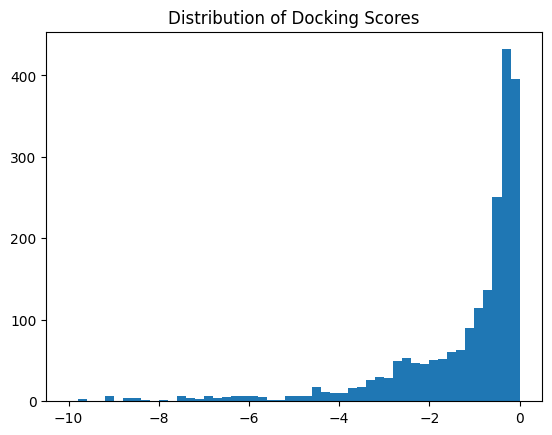

In [23]:
#Plotting score distriubution
plt.hist(s3, range=[-10,0], bins=50)
plt.title("Distribution of Docking Scores")

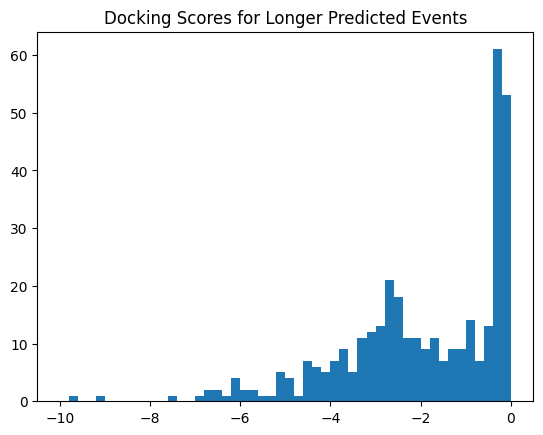

Text(0.5, 1.0, 'Docking Scores for Shorter Predicted Events')

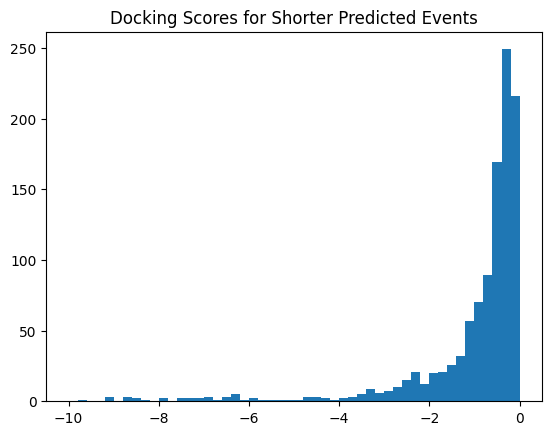

In [36]:
#Plotting scores distriubution
s1 = s3[ap2 > 100]
s2 = s3[ap2 < 25]
plt.hist(s1, range=[-10,0], bins=50)
plt.title("Docking Scores for Longer Predicted Events")
plt.show()
plt.clf()
plt.hist(s2, range=[-10,0], bins=50)
plt.title("Docking Scores for Shorter Predicted Events")

In [20]:
#Scaling preds back to normal
print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

[0.17513461 0.07712692 0.11978975 ... 0.06142583 0.20250767 1.5468552 ]
[0.05 0.05 0.05 ... 0.07 0.17 1.58]
49.1998
52.24667258207631


r2: 0.7734280168868601


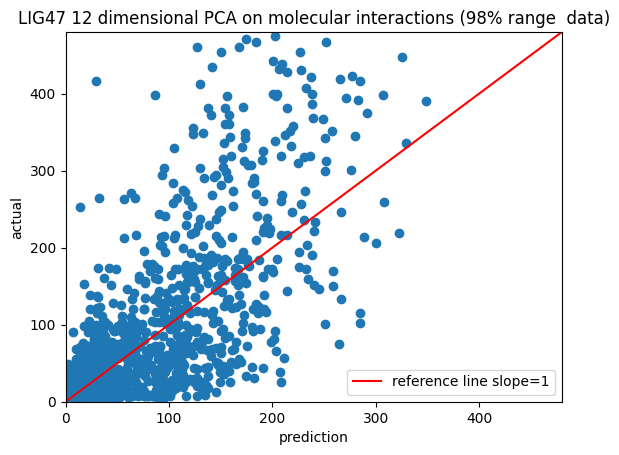

In [22]:
#Plotting correlation between predictions and ground truth
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 480,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 12 dimensional PCA on molecular interactions (98% range  data)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.xlim([0,480])
plt.ylim([0,480])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


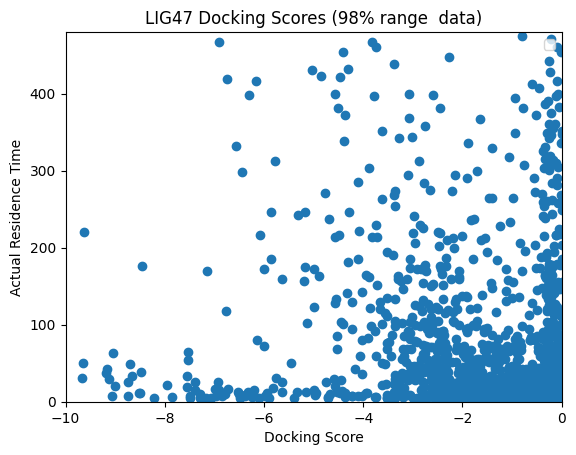

In [43]:
#Plotting correlation between docking scores and ground truth
plt.scatter(s3,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
plt.title("LIG47 Docking Scores (98% range  data)")
plt.ylabel('Actual Residence Time')
plt.legend()
plt.xlabel('Docking Score')
plt.ylim([0,480])
plt.xlim([-10,0])
plt.show()